# Importing library

In [49]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
import matplotlib.pyplot as plt
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import numpy as np
from tensorflow.keras import mixed_precision# type: ignore
import pickle
from sklearn.metrics import classification_report, ConfusionMatrixDisplay,confusion_matrix

In [2]:
tf.keras.backend.clear_session()

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

# Load the dataset

In [4]:
data = pd.read_json('News_Category_Dataset_v3.json',lines=True)

In [5]:
data.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


# Data visualization

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [7]:
data['category'].value_counts()

POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3653
WOMEN              3572
CRIME              3562
IMPACT             3484
DIVORCE            3426
WORLD NEWS         3299
MEDIA              2944
WEIRD NEWS         2777
GREEN              2622
WORLDPOST          2579
RELIGION           2577
STYLE              2254
SCIENCE            2206
TECH               2104
TASTE              2096
MONEY              1756
ARTS               1509
ENVIRONMENT        1444
FIFTY              1401
GOOD NEWS          1398
U.S. NEWS          1377
ARTS & CULTURE     1339
COLLEGE            1144
LATINO VOICES      1130
CULTURE & ARTS     1074
EDUCATION       

In [8]:
len(data['category'].value_counts())

42

In [9]:
len(data)

209527

# Data preprocessing

The headlines and short description of the news will be used for the model to train

In [10]:
data['text'] = data['headline'] + ' ' + data['short_description']

In [11]:
data['text'][0]

'Over 4 Million Americans Roll Up Sleeves For Omicron-Targeted COVID Boosters Health experts said it is too early to predict whether demand would match up with the 171 million doses of the new boosters the U.S. ordered for the fall.'

Filter unnecessary categories from the dataset

In [12]:
categories_to_keep = [
    'POLITICS', 'WELLNESS', 'ENTERTAINMENT', 'TRAVEL',
    'BUSINESS', 'SPORTS', 'TECH', 'SCIENCE',
    'HEALTHY LIVING', 'RELIGION'
]

data = data[data['category'].isin(categories_to_keep)]
data.head()

,link,headline,category,short_description,authors,date,text
13,https://www.huffpost.com/entry/twitch-streamer...,Twitch Bans Gambling Sites After Streamer Scam...,TECH,One man's claims that he scammed people on the...,Ben Blanchet,2022-09-21,Twitch Bans Gambling Sites After Streamer Scam...
17,https://www.huffpost.com/entry/dodgers-basebal...,"Maury Wills, Base-Stealing Shortstop For Dodge...",SPORTS,"Maury Wills, who helped the Los Angeles Dodger...","Beth Harris, AP",2022-09-20,"Maury Wills, Base-Stealing Shortstop For Dodge..."
20,https://www.huffpost.com/entry/golden-globes-r...,Golden Globes Returning To NBC In January Afte...,ENTERTAINMENT,"For the past 18 months, Hollywood has effectiv...",,2022-09-20,Golden Globes Returning To NBC In January Afte...
21,https://www.huffpost.com/entry/biden-us-forces...,Biden Says U.S. Forces Would Defend Taiwan If ...,POLITICS,President issues vow as tensions with China rise.,,2022-09-19,Biden Says U.S. Forces Would Defend Taiwan If ...
24,https://www.huffpost.com/entry/ukraine-festiva...,‘Beautiful And Sad At The Same Time’: Ukrainia...,POLITICS,An annual celebration took on a different feel...,Jonathan Nicholson,2022-09-19,‘Beautiful And Sad At The Same Time’: Ukrainia...


In [13]:
data['category'].value_counts()

POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
HEALTHY LIVING     6694
BUSINESS           5992
SPORTS             5077
RELIGION           2577
SCIENCE            2206
TECH               2104
Name: category, dtype: int64

Combine HEALTHY LIVING and WELLNESS into one category since they are related

In [14]:
data['category'] = data['category'].replace('HEALTHY LIVING', 'WELLNESS')
data['category'].value_counts()

POLITICS         35602
WELLNESS         24639
ENTERTAINMENT    17362
TRAVEL            9900
BUSINESS          5992
SPORTS            5077
RELIGION          2577
SCIENCE           2206
TECH              2104
Name: category, dtype: int64

Combine TECH and Science into one category since they are related

In [15]:
data['category'] = data['category'].replace(['TECH', 'SCIENCE'], 'TECH and SCIENCE')
data['category'].value_counts()

POLITICS            35602
WELLNESS            24639
ENTERTAINMENT       17362
TRAVEL               9900
BUSINESS             5992
SPORTS               5077
TECH and SCIENCE     4310
RELIGION             2577
Name: category, dtype: int64

Discarding RELIGION category since the data is quite low.

Hence, these 7 categories will be used as the labels for classification task

In [16]:
data = data[data['category'] != 'RELIGION']
data['category'].value_counts()

POLITICS            35602
WELLNESS            24639
ENTERTAINMENT       17362
TRAVEL               9900
BUSINESS             5992
SPORTS               5077
TECH and SCIENCE     4310
Name: category, dtype: int64

Dropping unnecessary columns

In [17]:
columns_to_drop = ['authors','link','headline','short_description','date']

data.drop(columns=columns_to_drop,inplace=True)

In [18]:
data.head()

,category,text
13,TECH and SCIENCE,Twitch Bans Gambling Sites After Streamer Scam...
17,SPORTS,"Maury Wills, Base-Stealing Shortstop For Dodge..."
20,ENTERTAINMENT,Golden Globes Returning To NBC In January Afte...
21,POLITICS,Biden Says U.S. Forces Would Defend Taiwan If ...
24,POLITICS,‘Beautiful And Sad At The Same Time’: Ukrainia...


Balancing the dataset

In [19]:
RUS = RandomUnderSampler(random_state=42)

x = data.drop(columns=['category'])
y = data['category']

x_resampled, y_resampled = RUS.fit_resample(x,y)

data = pd.concat([x_resampled,y_resampled],axis=1,join='inner')

In [20]:
data['category'].value_counts()

BUSINESS            4310
ENTERTAINMENT       4310
POLITICS            4310
SPORTS              4310
TECH and SCIENCE    4310
TRAVEL              4310
WELLNESS            4310
Name: category, dtype: int64

Label Encoding

In [21]:
encoder = LabelEncoder()
data['category'] = encoder.fit_transform(data['category'])

In [22]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased',num_labels = 7)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_transform', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'classifier', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

Splitting dataset into training, validation and testing set

80% for training, 10% for validation and 10% for testing

In [23]:
train_data, temp_data = train_test_split(data,test_size=0.2,random_state=42,stratify=data['category'])

val_data, test_data = train_test_split(temp_data,test_size=0.5,random_state=42,stratify=temp_data['category'])

In [24]:
print("Training data: ",len(train_data))
print("Validation data: ",len(val_data))
print("Testing data: ",len(test_data))

Training data:  24136
Validation data:  3017
Testing data:  3017


# Formatting data for the model to use

In [25]:
y_train = train_data['category'].values
y_val = val_data['category'].values
y_test = test_data['category'].values

In [26]:
# Tokenize the text data
tokenized_train = tokenizer(list(train_data['text']), truncation=True, padding=False)
tokenized_val = tokenizer(list(val_data['text']), truncation=True, padding=False)
tokenized_test = tokenizer(list(test_data['text']), truncation=True, padding=False)

# Find the maximum length of the tokenized sequences
max_length_train = max([len(seq) for seq in tokenized_train['input_ids']])
max_length_val = max([len(seq) for seq in tokenized_val['input_ids']])
max_length_test = max([len(seq) for seq in tokenized_test['input_ids']])

# Determine the overall maximum length
max_length = max(max_length_train, max_length_val, max_length_test)
print("Maximum length for padding after tokenization:", max_length)

Maximum length for padding after tokenization: 353


In [27]:
train_data = tokenizer(list(train_data['text']),truncation=True,padding='max_length',max_length = max_length, return_tensors='tf')
test_data = tokenizer(list(test_data['text']),truncation=True,padding='max_length',max_length = max_length, return_tensors='tf')
val_data = tokenizer(list(val_data['text']),truncation=True,padding='max_length',max_length = max_length,return_tensors='tf')

In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_data),
    y_train
)).batch(2)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_data),
    y_val
)).batch(2)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_data),
    y_test
)).batch(2)

In [29]:
train_dataset

<BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 353), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 353), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

# Model's parameter

In [30]:
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMai  multiple                 66362880  
 nLayer)                                                         
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  5383      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66,958,855
Trainable params: 66,958,855
Non-trainable params: 0
_________________________________________________________________


In [31]:
type(model)

transformers.models.distilbert.modeling_tf_distilbert.TFDistilBertForSequenceClassification

# Training the model

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(5e-6),metrics=['accuracy'])

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [33]:
early_stopping = tf.keras.callbacks.EarlyStopping(verbose=1,patience=2,monitor='val_loss')

In [34]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU, compute capability 8.6


In [35]:
history = model.fit(train_dataset, validation_data=val_dataset,epochs=5,callbacks=[early_stopping])

Epoch 1/5
12068/12068 [==============================] - 1954s 161ms/step - loss: 0.6271 - accuracy: 0.8083 - val_loss: 0.4280 - val_accuracy: 0.8621
Epoch 2/5
12068/12068 [==============================] - 1957s 162ms/step - loss: 0.3487 - accuracy: 0.8940 - val_loss: 0.4203 - val_accuracy: 0.8694
Epoch 3/5
12068/12068 [==============================] - 1947s 161ms/step - loss: 0.2254 - accuracy: 0.9344 - val_loss: 0.4240 - val_accuracy: 0.8764
Epoch 4/5
12068/12068 [==============================] - 1939s 161ms/step - loss: 0.1411 - accuracy: 0.9608 - val_loss: 0.5087 - val_accuracy: 0.8618
Epoch 4: early stopping


# Evaluating the model

In [36]:
loss,accuracy = model.evaluate(test_dataset)

1509/1509 [==============================] - 76s 51ms/step - loss: 0.5599 - accuracy: 0.8542


In [37]:
print('Accuracy: ',accuracy)
print('Loss: ',loss)

Accuracy:  0.8541597723960876
Loss:  0.5598673224449158


# Saving model, label encoder, and tokenizer

In [38]:
model.save_pretrained('distilbert_news_model')

In [39]:
tokenizer.save_pretrained('distilbert_news_tokenizer')

('distilbert_news_tokenizer\\tokenizer_config.json',
 'distilbert_news_tokenizer\\special_tokens_map.json',
 'distilbert_news_tokenizer\\vocab.txt',
 'distilbert_news_tokenizer\\added_tokens.json',
 'distilbert_news_tokenizer\\tokenizer.json')

In [40]:
with open('label_encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)

# Classification report and confusion matrix

Load the model

In [40]:
model = TFAutoModelForSequenceClassification.from_pretrained('distilbert_news_model')
model.load_weights('distilbert_news_model/tf_model.h5')

Some layers from the model checkpoint at distilbert_news_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert_news_model and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Get prediction

In [44]:
model.compile(optimizer=tf.keras.optimizers.Adam(5e-6),metrics=['accuracy'])
prediction = model.predict(test_dataset)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


1509/1509 [==============================] - 83s 54ms/step


In [46]:
print(classification_report(y_test,np.argmax(prediction.logits,axis=1),target_names=encoder.classes_))

                  precision    recall  f1-score   support

        BUSINESS       0.78      0.78      0.78       431
   ENTERTAINMENT       0.87      0.90      0.88       431
        POLITICS       0.85      0.86      0.85       431
          SPORTS       0.92      0.94      0.93       431
TECH and SCIENCE       0.84      0.74      0.78       431
          TRAVEL       0.88      0.93      0.91       431
        WELLNESS       0.83      0.83      0.83       431

        accuracy                           0.85      3017
       macro avg       0.85      0.85      0.85      3017
    weighted avg       0.85      0.85      0.85      3017



<Figure size 1000x600 with 0 Axes>

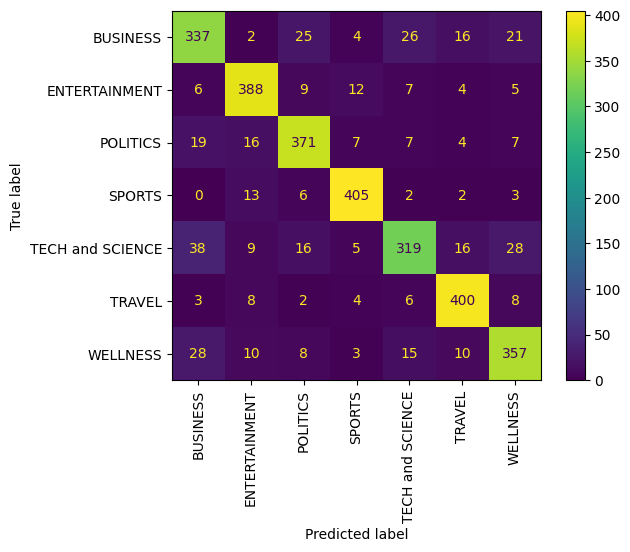

In [63]:
plt.figure(figsize=(10,6))
ConfusionMatrixDisplay(confusion_matrix(y_test,np.argmax(prediction.logits,axis=1)),display_labels=encoder.classes_).plot()
plt.xticks(rotation=90)
plt.show()

# Predicting sample text

In [43]:
def predict_text(sample_text):
    tokenized_sample = tokenizer(sample_text, truncation=True, padding='max_length', max_length=353, return_tensors='tf')

    predictions = model(tokenized_sample)

    predicted_label = tf.argmax(predictions.logits, axis=1).numpy()

    decoded_label = encoder.inverse_transform(predicted_label)

    return  decoded_label[0]

In [44]:
# Sample text for prediction
sample_text = ["""
As we have become accustomed to, when Arsenal are in need, up steps No. 7 and Bukayo Saka tore apart Southamption at the Emirates, much to the delight of Mikel Arteta.

The winger registered two assists before getting in on the goal-scoring himself with a well-taken effort in stoppage time to put an exclamation mark on yet another outstanding performance.

Saka's first pass to Kai Havertz was beautifully weighted and the German took a touch before lashing home to bring the Gunners level. His second was a delicious lob to the back post to find an onrushing Gabriel Martinelli and the Brazilian tapped home from close range.

Such was Bukayo's performance, Arteta detailed that is the kind of maturity the winger is playing with now.
               """]

print("Predicted category:", predict_text(sample_text))

Predicted category: SPORTS


In [45]:
sample_text = ["""
Physical activity impacts mental health. Exercise has consistently been shown to effectively reduce symptoms of depression and maintain well-being both as a primary treatment and in conjunction with medication or therapy. There is also evidence that exercise benefits individuals with posttraumatic stress disorder (PTSD), anxiety, and attention-deficit/hyperactivity disorder (ADHD).

Physical activity may also help prevent cognitive decline in older adults. More broadly, regular exercise positively impacts cognitive function and increases neuroplasticity (the brain’s ability to change) which can enhance learning and adaptation. Physical activity can take many forms—walking, running, fitness classes, organized sports, etc. Much of the research has focused on the benefits of aerobic exercise and resistance training, such as weight training.

Exercise “snacks,” or brief episodes of exercise interspersed throughout the day, can be an easy way to incorporate daily movement into daily routines. This could involve a few minutes of climbing stairs or jumping jacks or pushups. Some people report using these brief exercise breaks every hour or so during sedentary tasks also helps with attention and concentration, which can give the added benefit of improved productivity.
"""]

print("Predicted category:", predict_text(sample_text))

Predicted category: WELLNESS


In [46]:
sample_text = ["""
After rushing to comfort Israel as it grieved the worst attack on Jews since the Holocaust, President Joe Biden last year pledged America would stand with the country in its dark days and the good ones he insisted would come.

At the time, no one knew the international and domestic political consequences of his promise. An ensuing war has proved the existential role the US plays in Israel’s survival but also severely strained the alliance. It has also exposed and widened some of America’s most profound political divides ahead of an already tumultuous election between Vice President Kamala Harris and former President Donald Trump next month.

The October 7, 2023, Hamas terror attacks, which killed 1,200 people, did not just transform the Middle East’s strategic balance as Israel confronted Hamas, then Hezbollah, and traded fire with their sponsor, its archenemy, Iran. Like the September 11 attacks in 2001, the Hamas horror set off a chain of events that affected countless lives, unleashing political disturbances thousands of miles away.
"""]

print("Predicted category:", predict_text(sample_text))

Predicted category: POLITICS
